Changes from v2

- implemented the possiblity to add nodes to the system
- add new visualization based data frame

**Importing Dependencies**

In [1]:
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

# Import stable baselines
# Probably not needed --> test ray lib instead
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

**Configuration of the Scenario**

In [6]:
# Configuration of the network
# Sample JSON configuration (replace this with your JSON data)
network_config = """
{
  "nodes": {
    "A": { "type": "manufacturer", "I": 30 },
    "B": { "type": "manufacturer", "I": 28 },
    "C": { "type": "manufacturer", "I": 32 },
    "D": { "type": "distributor" },
    "S": { "type": "source" }
  },
  "edges": [
    { "source": "S", "target": "A", "L": 3},
    { "source": "S", "target": "B", "L": 3},
    { "source": "S", "target": "C", "L": 3},
    { "source": "A", "target": "D", "L": 5, "D": 0 },
    { "source": "B", "target": "D", "L": 5, "D": 0 },
    { "source": "C", "target": "D", "L": 5, "D": 0 }
  ]
}
"""

# TODO : Implement configuaration for cost and demand

**Building the environment**

In [8]:
from Environment.env_v3 import *

EP_LENGTH = 30 # Length of the episode

env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

KeyError: 'D'

**Testng the environment**

In [14]:
from stable_baselines3.common.env_checker import check_env

env = SS_Mngmt_Env(render_mode="human")
check_env(env, warn=True)

In [15]:
env.action_space.sample()

4

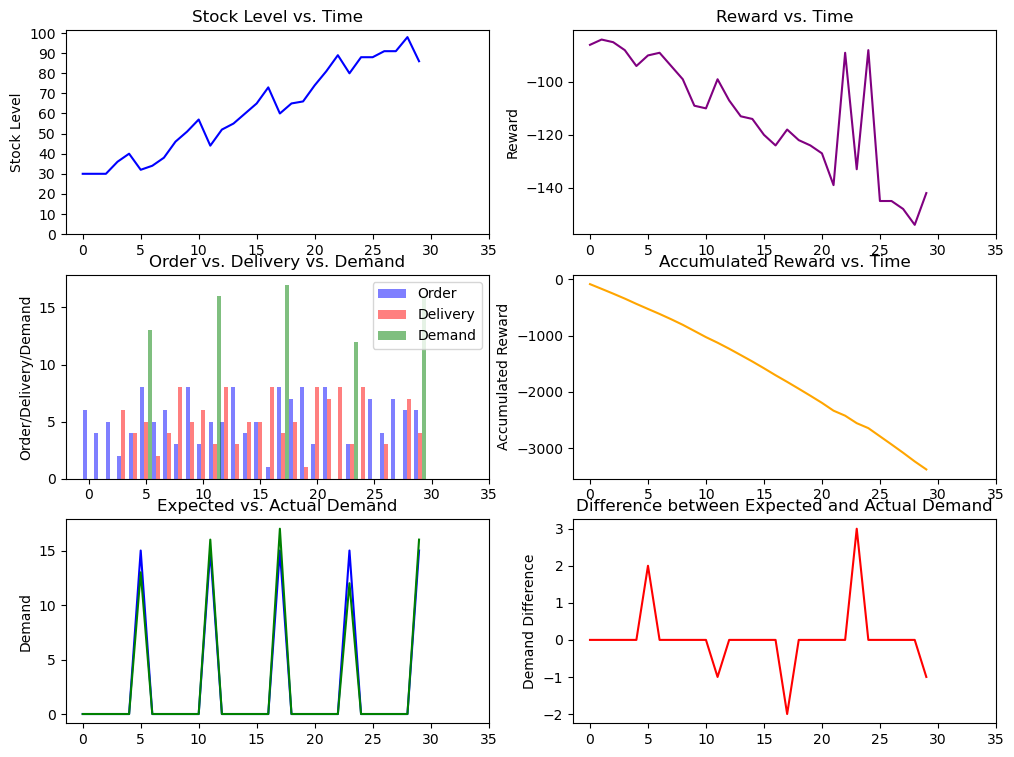

In [47]:
import numpy as np
import gymnasium as gym
import numpy as np

env = SS_Mngmt_Env(render_mode="human")

episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score += reward

        # print('Step t:{} Score:{} Stock:{} Order:{} Delivered:{} Exp Demand t+3:{} Act Demand:{}'.format((EP_LENGTH - env.episode_length), score, n_state[0], action, env.delivered, n_state[1], env.demand))

    env.render()

    # print(env.order_history)

**Train Model**

In [48]:
log_path = os.path.join('Training', 'Logs')
model_path = os.path.join('Training', 'Models', 'PPO')

In [49]:
env = SS_Mngmt_Env(render_mode="human")

# wrapping the environment in a vectorized environment
env = DummyVecEnv([lambda: env])

model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)

Using cpu device


In [50]:
model.learn(total_timesteps=100000)

Logging to Training/Logs/PPO_21
-----------------------------
| time/              |      |
|    fps             | 7038 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 4041        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005514547 |
|    clip_fraction        | 0.0199      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.3        |
|    explained_variance   | -5.58e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | 5.91e+05    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.006      |
|    value_loss           | 1.14e+06    |
-----------------------------------------
--

In [51]:
model.save(model_path)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
/var/folders/cz/9b93tcz93vxcjrq9_cqhnl3r0000gn/T/ipykernel_44910/582045589.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(3, 2, figsize=(12, 9)) # 1 row and 2 columns


([-3038.0], [30])

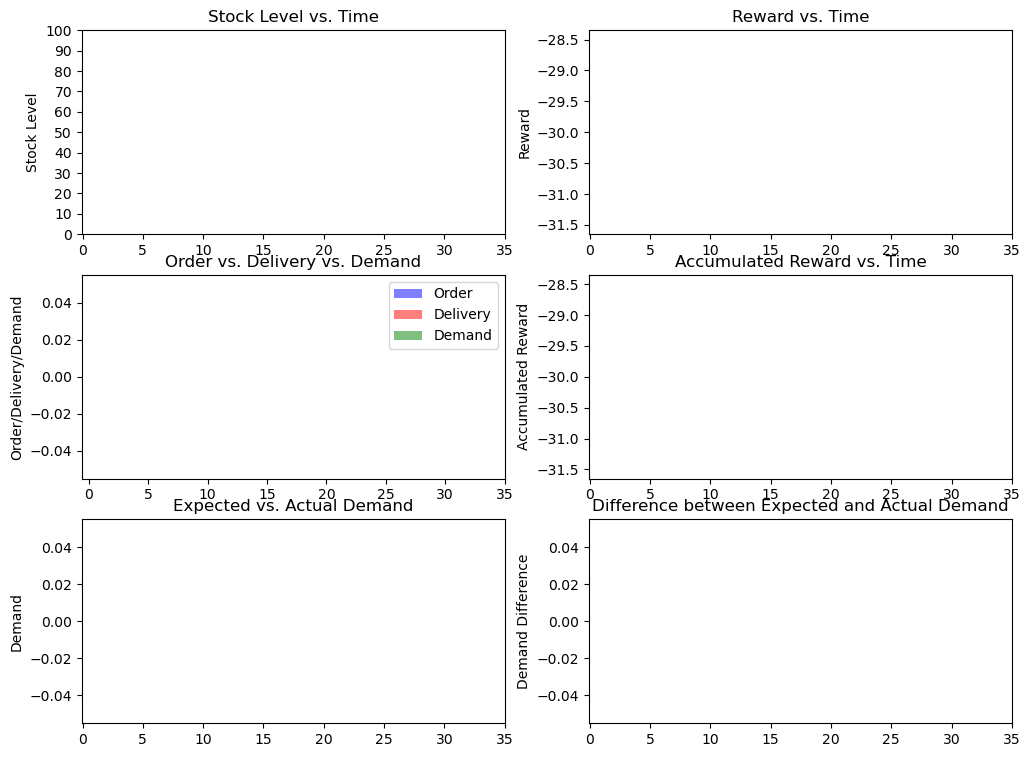

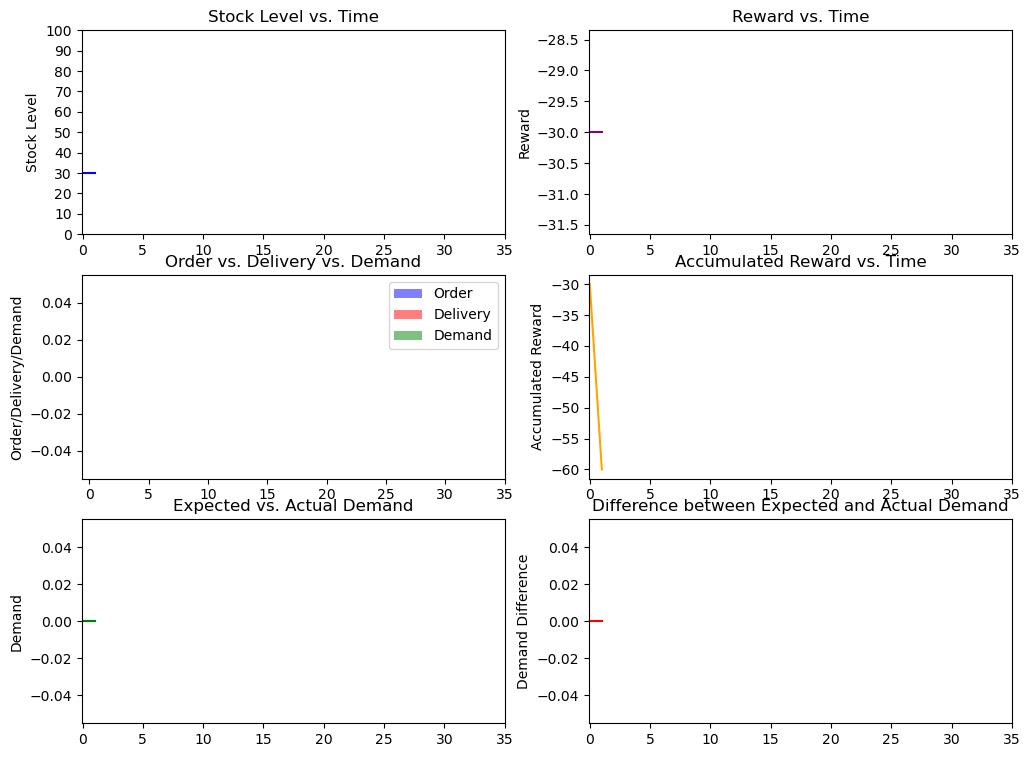

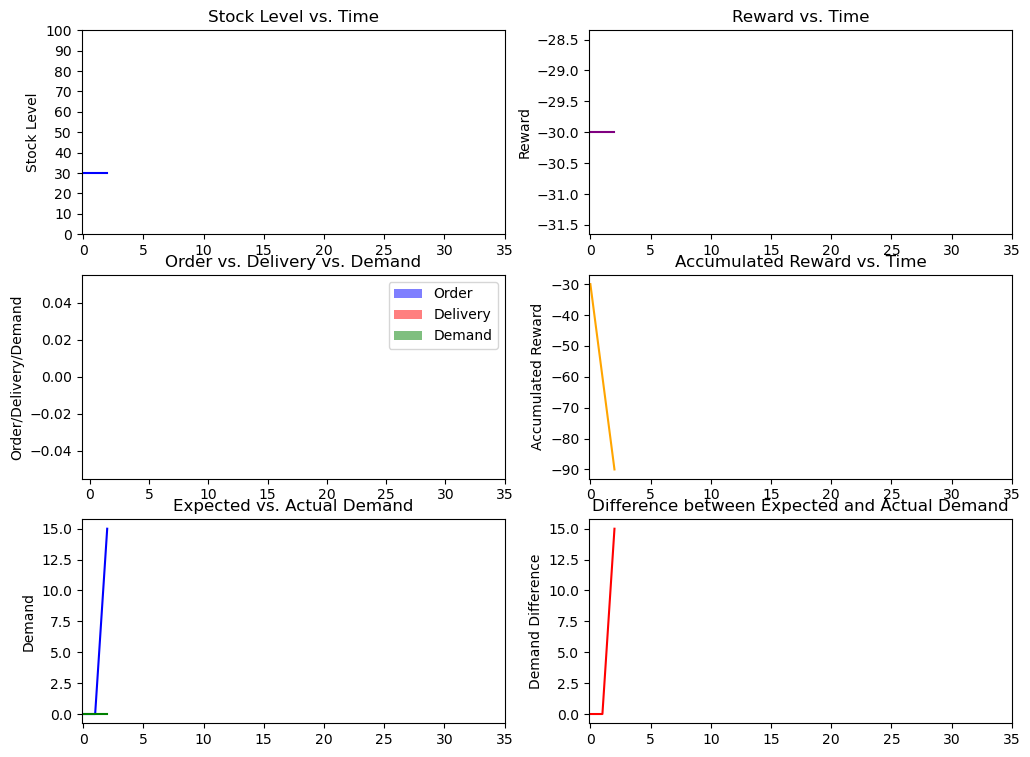

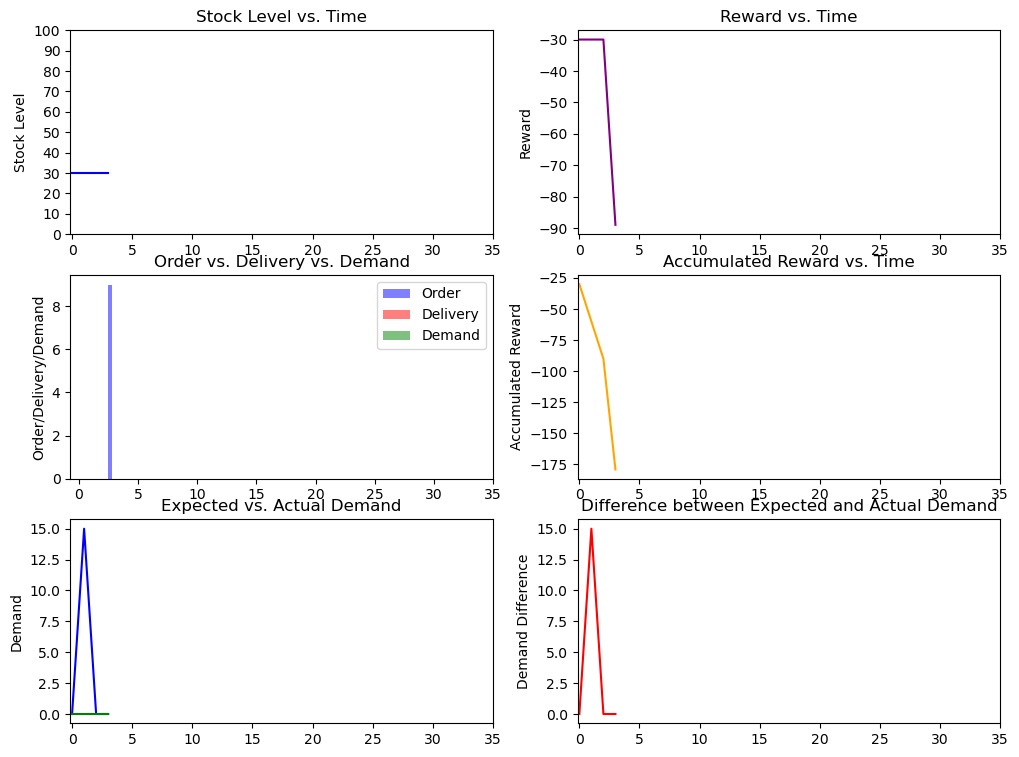

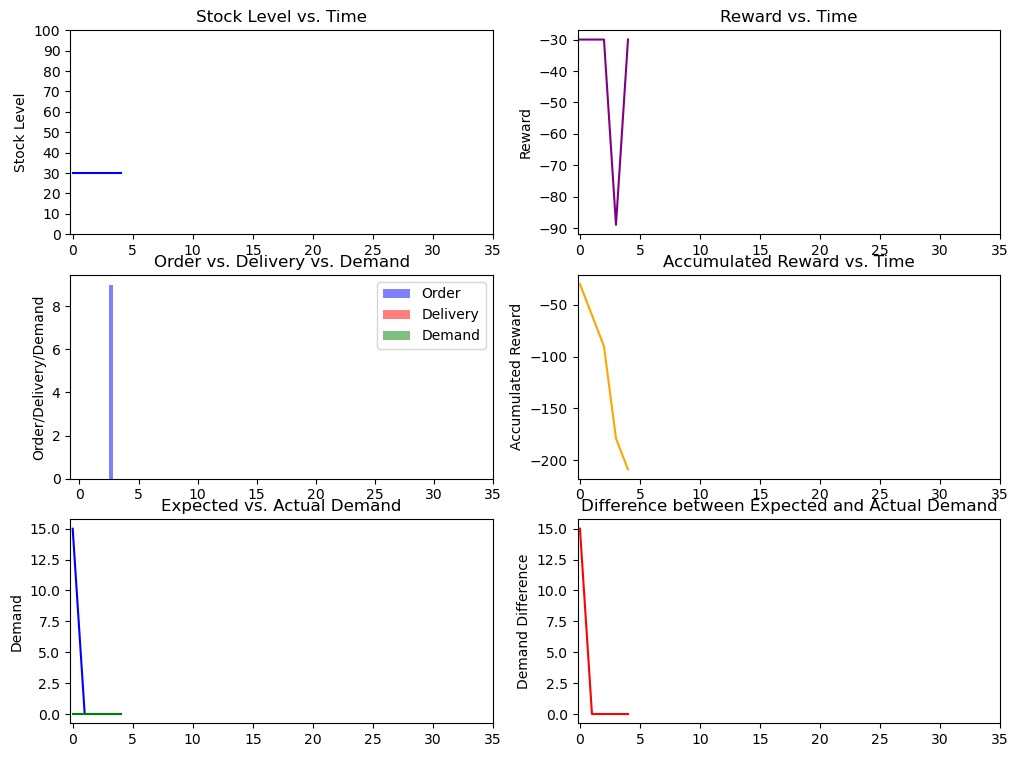

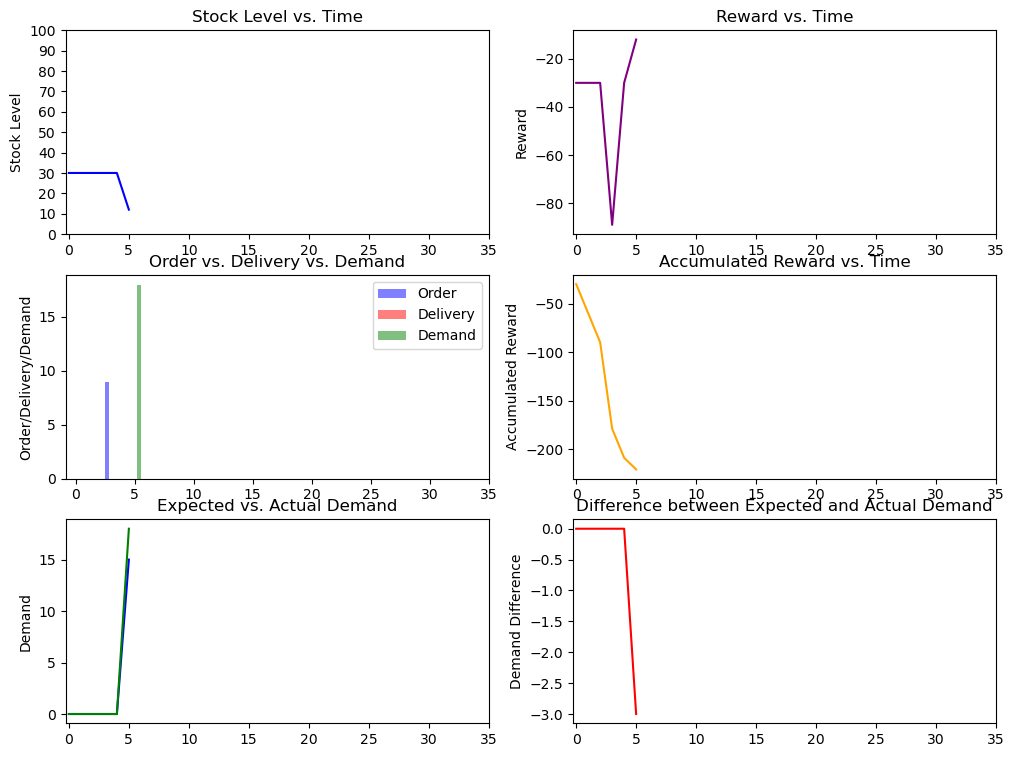

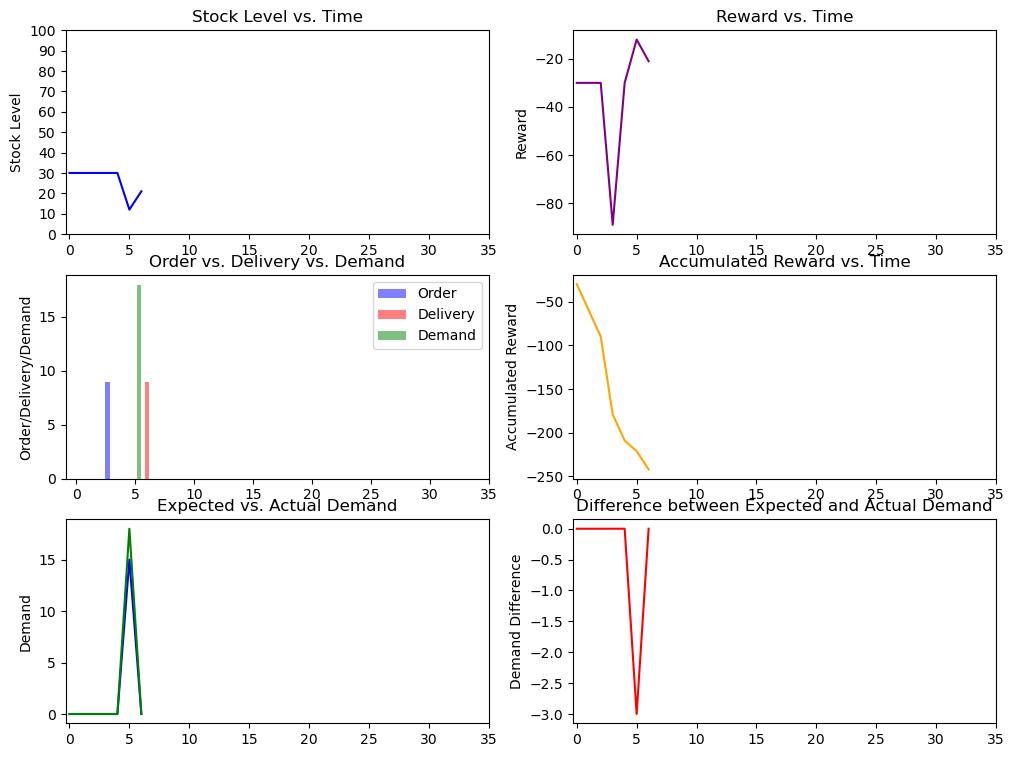

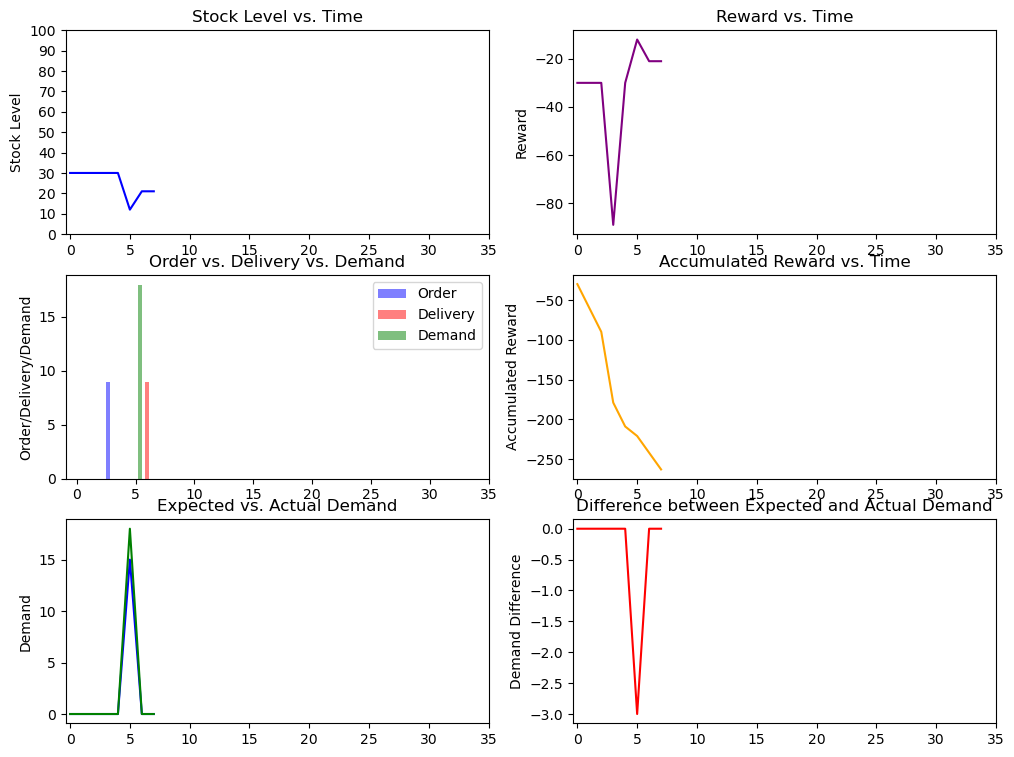

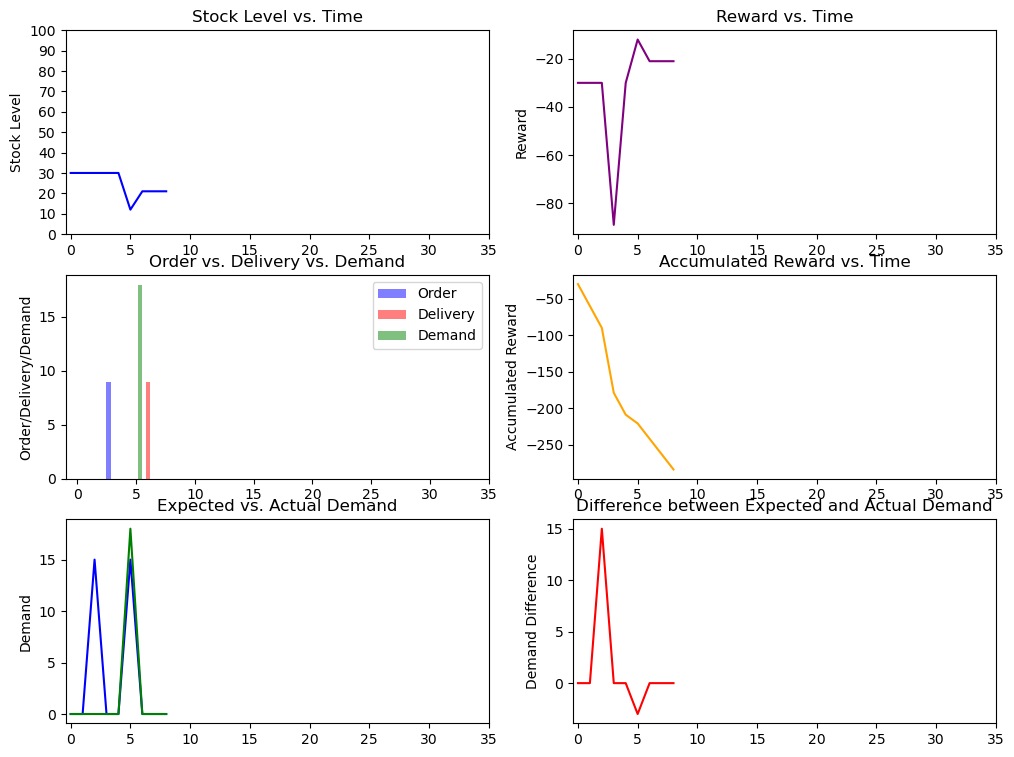

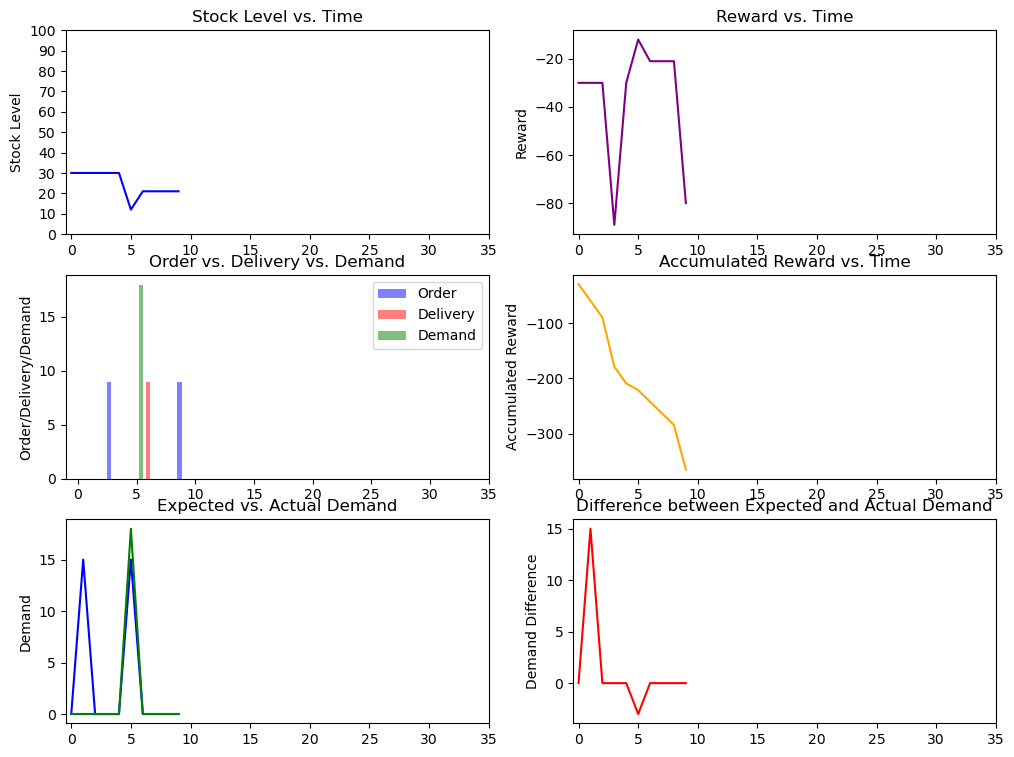

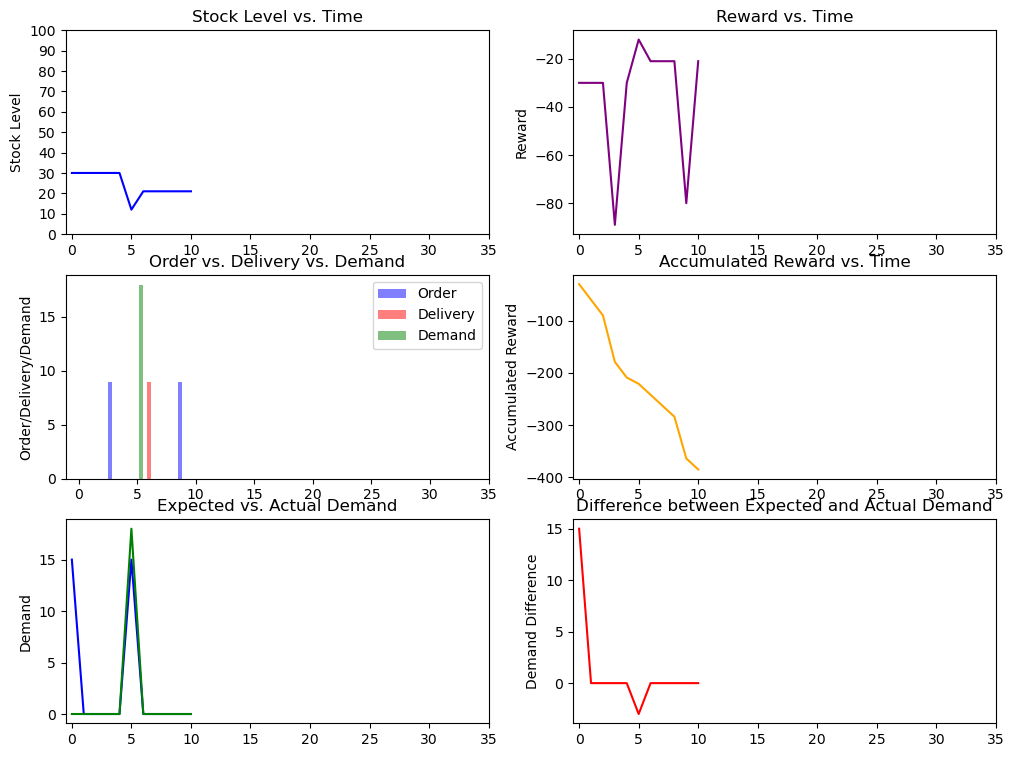

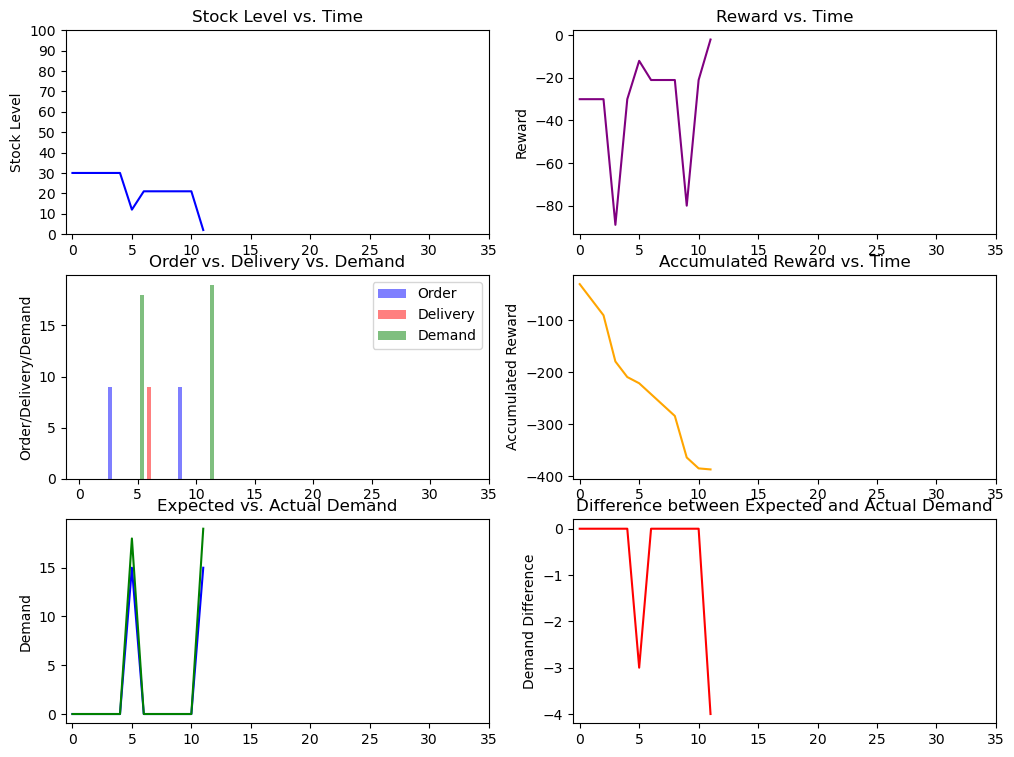

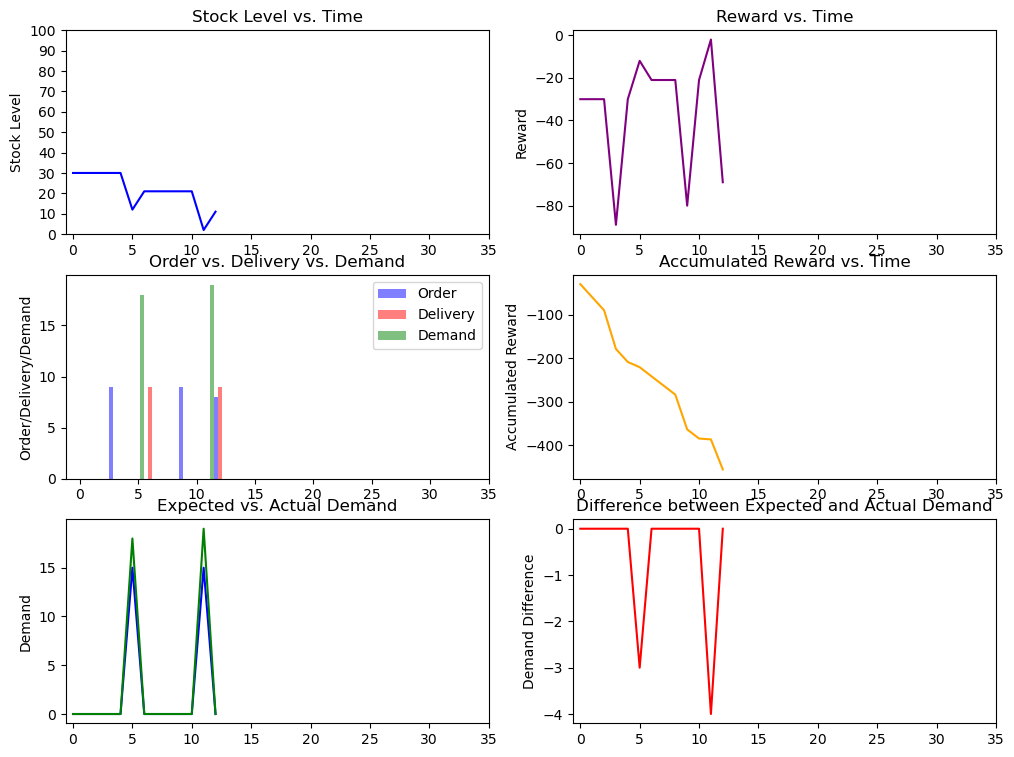

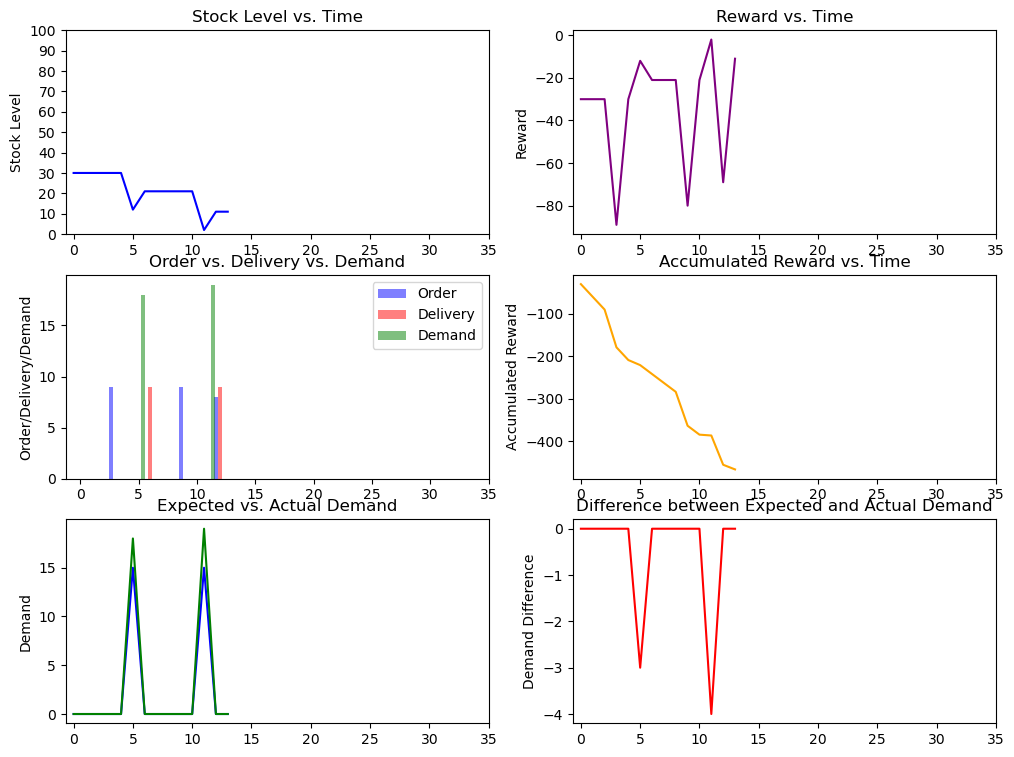

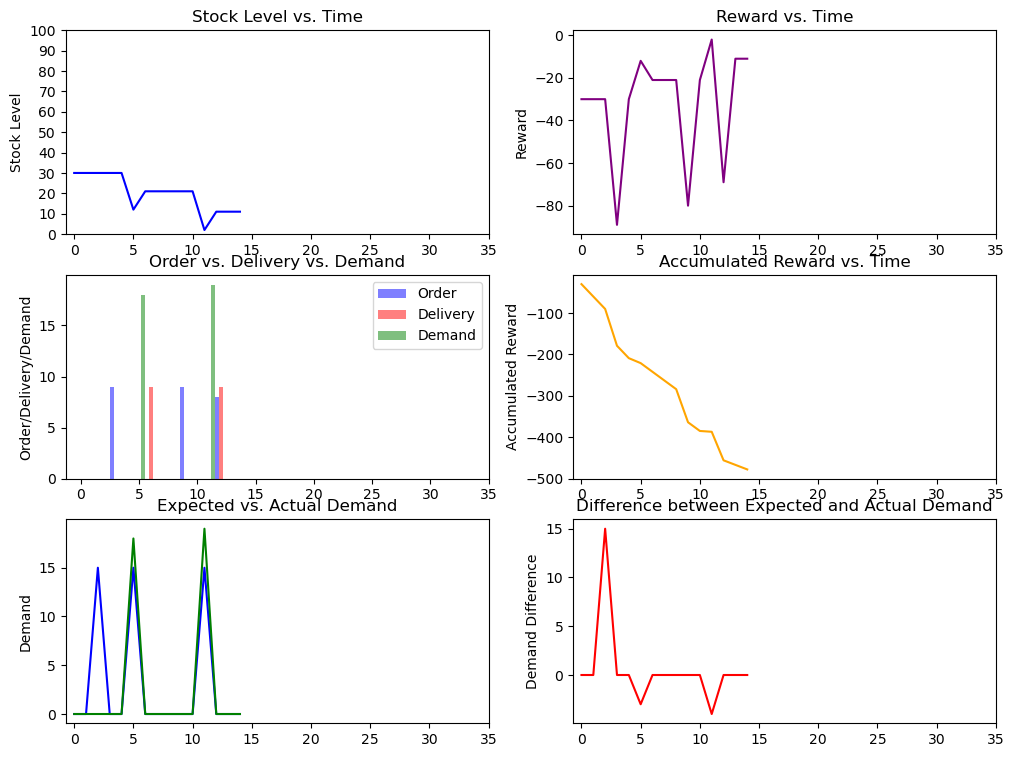

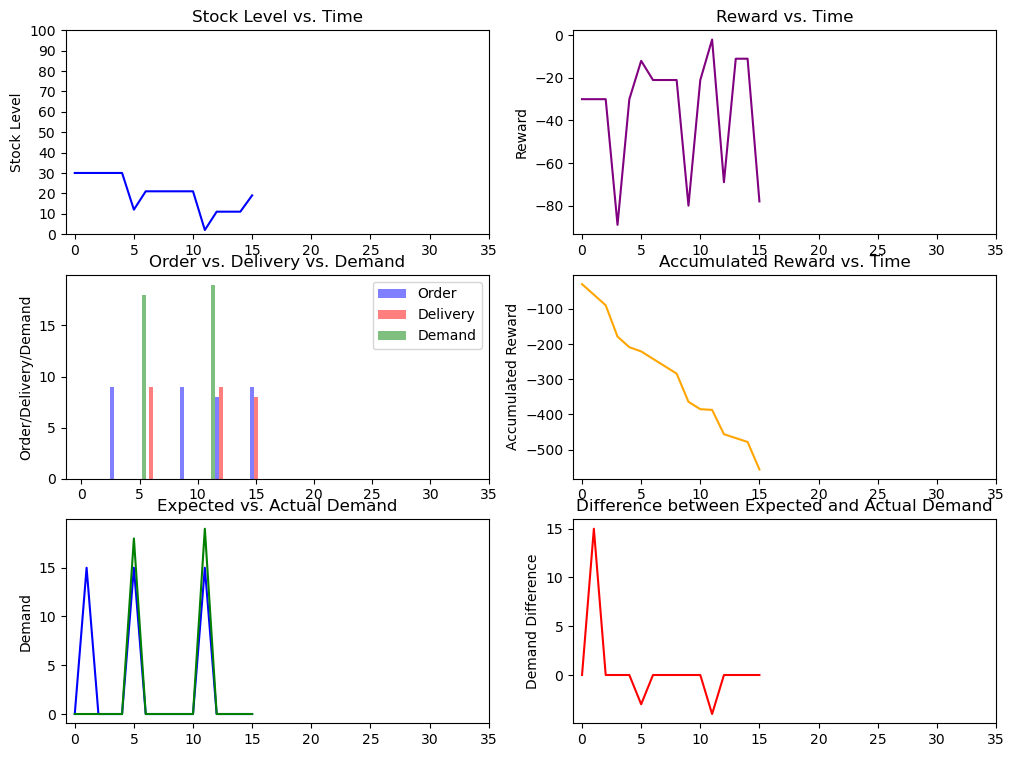

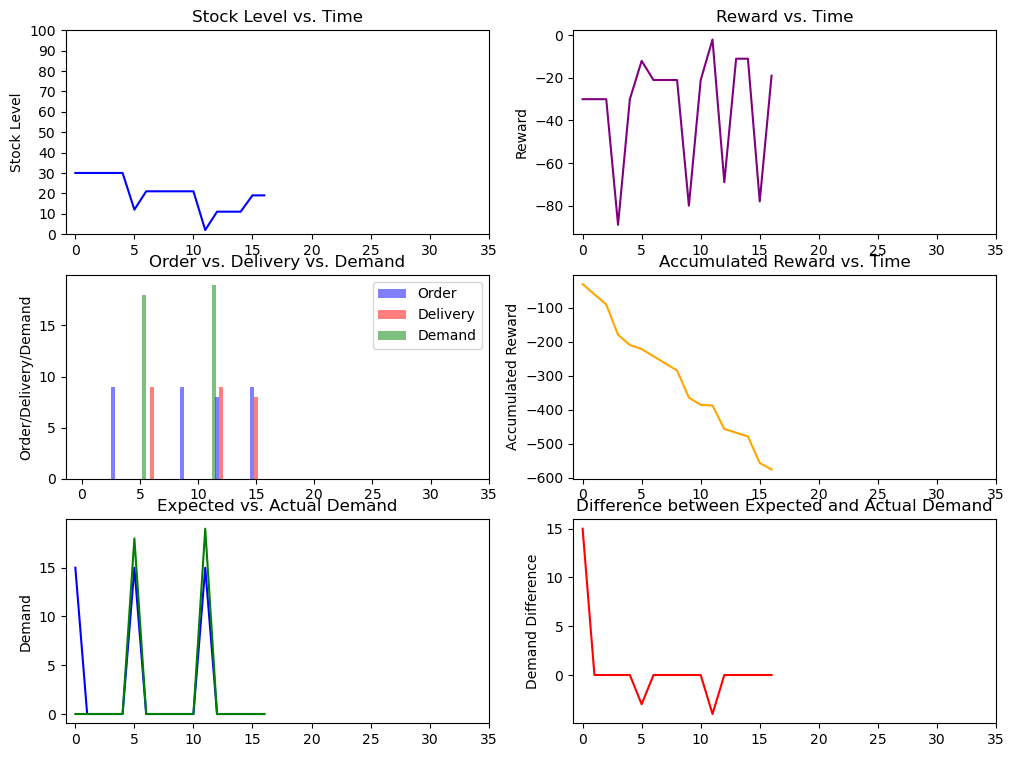

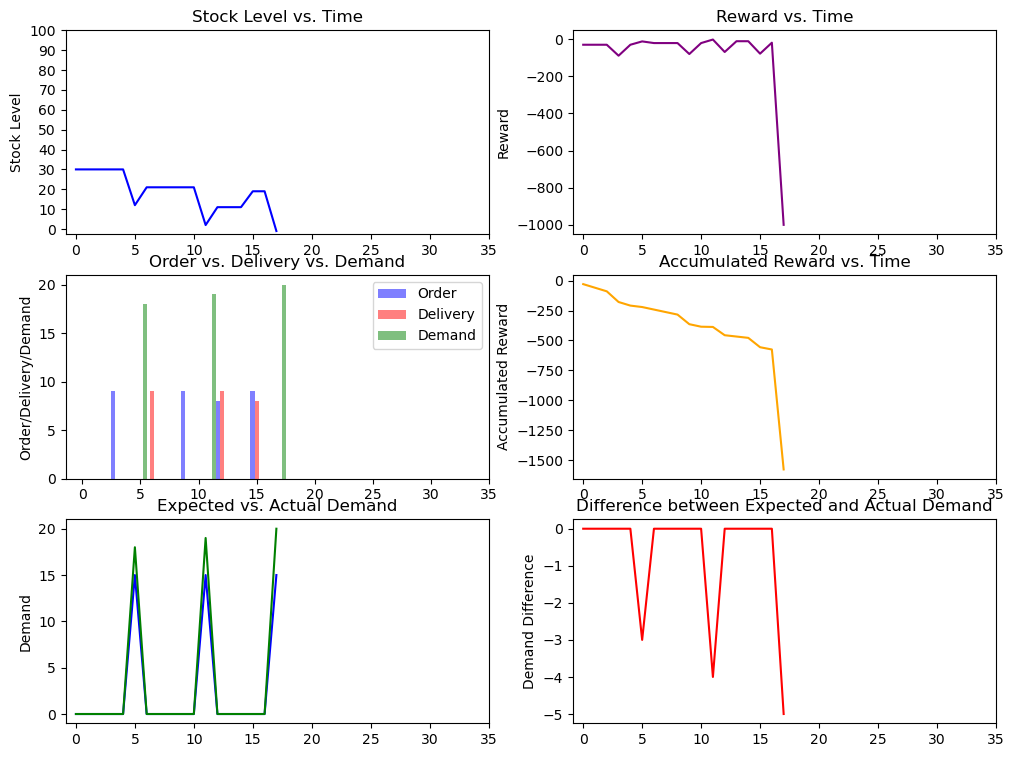

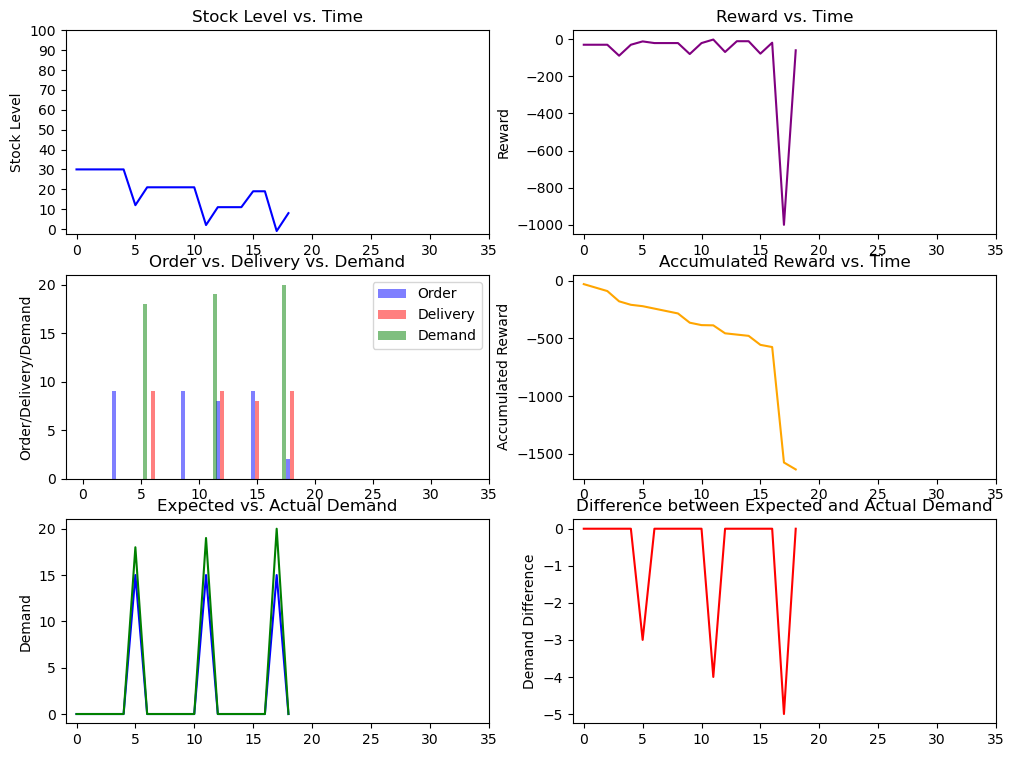

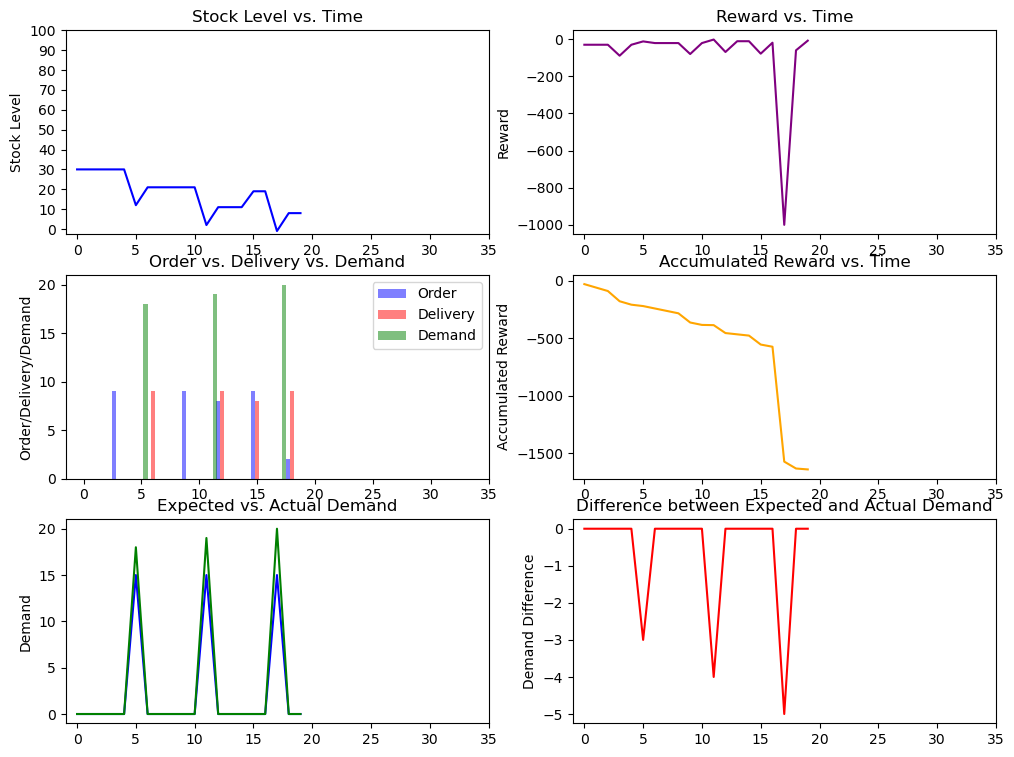

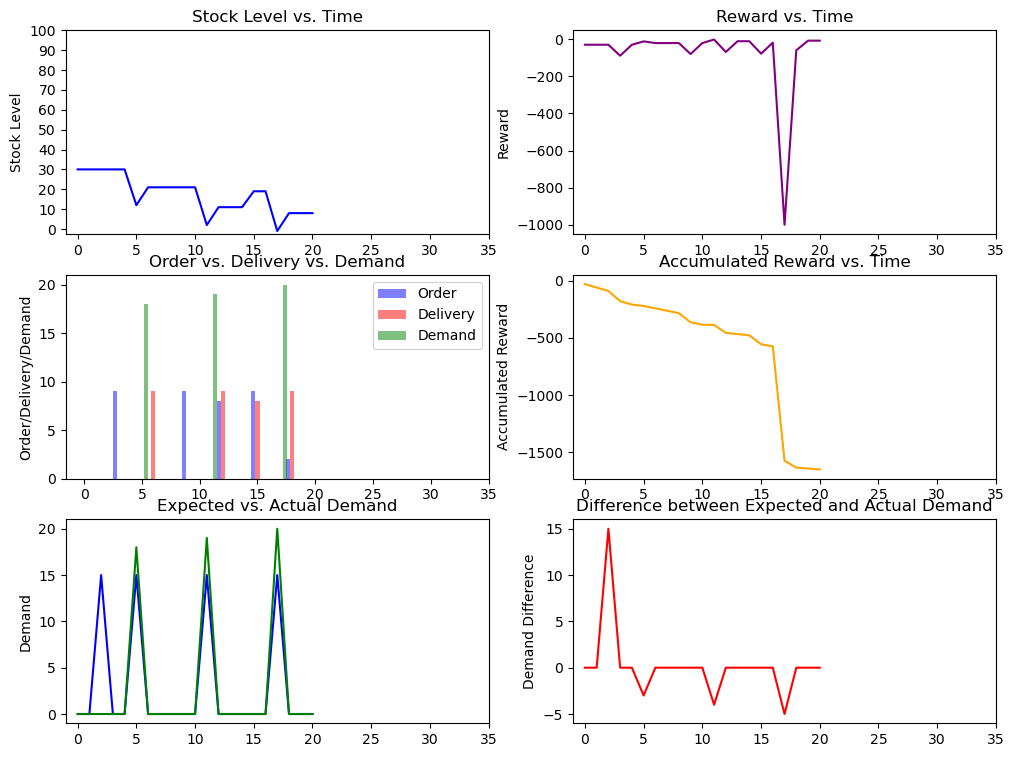

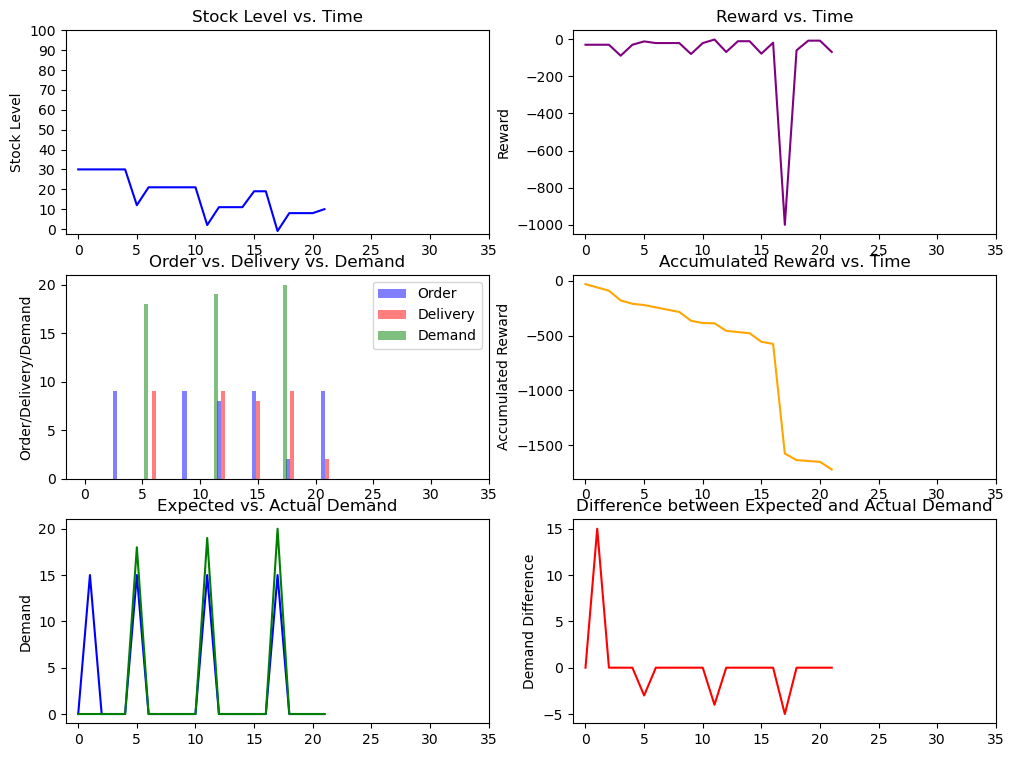

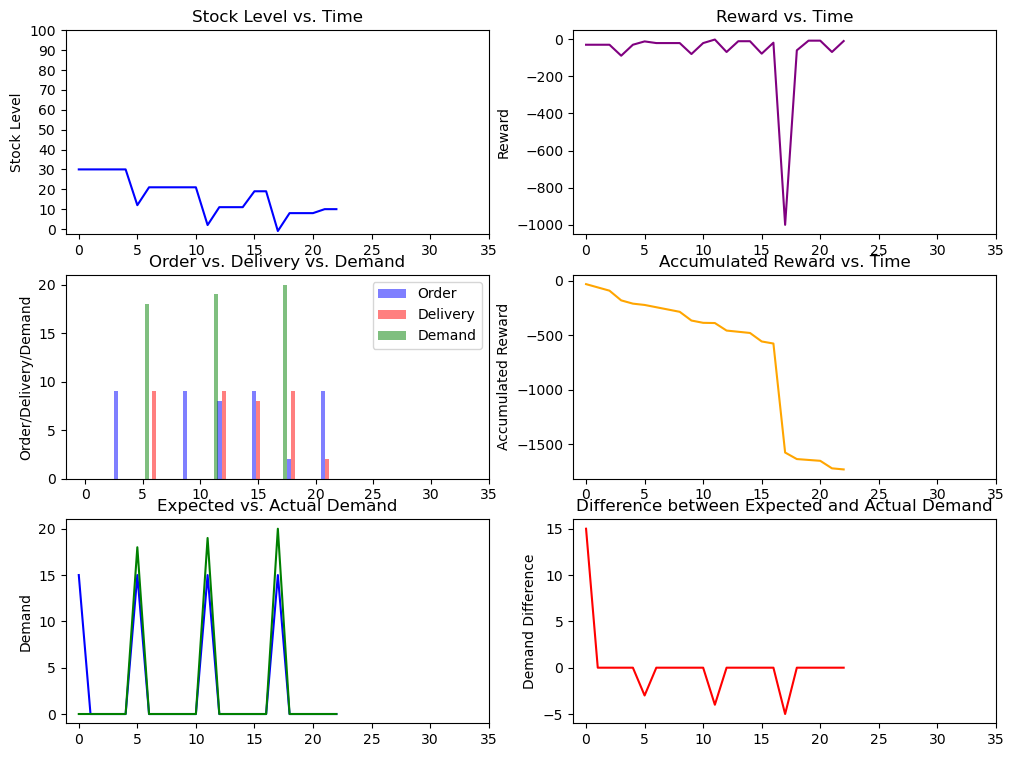

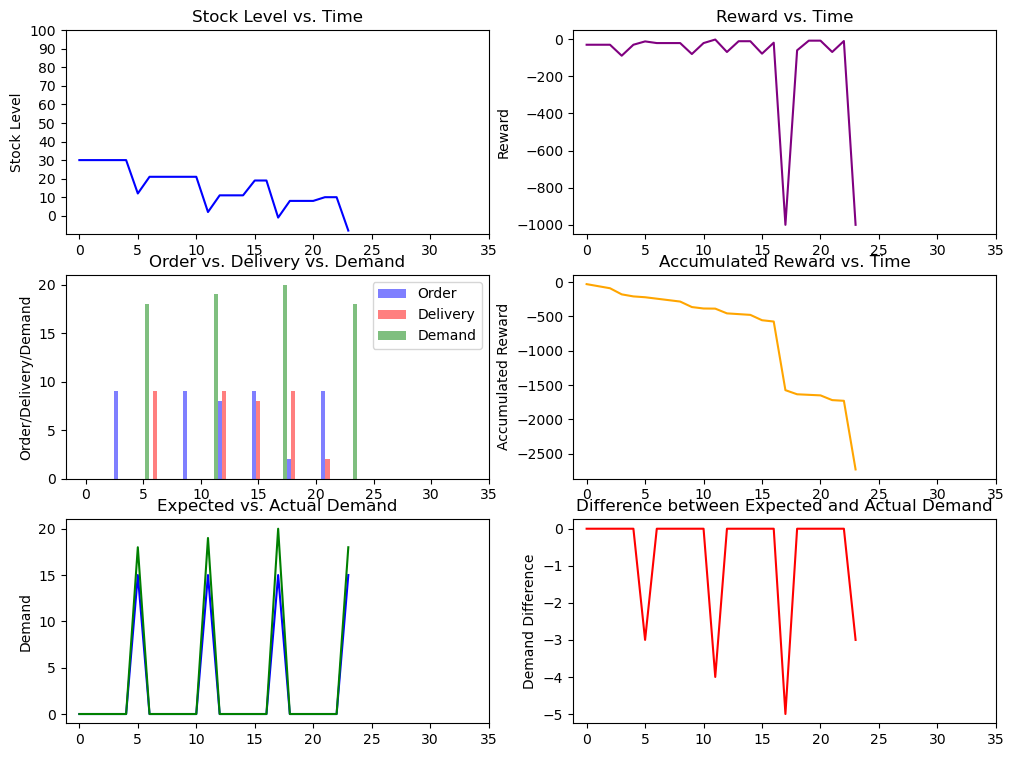

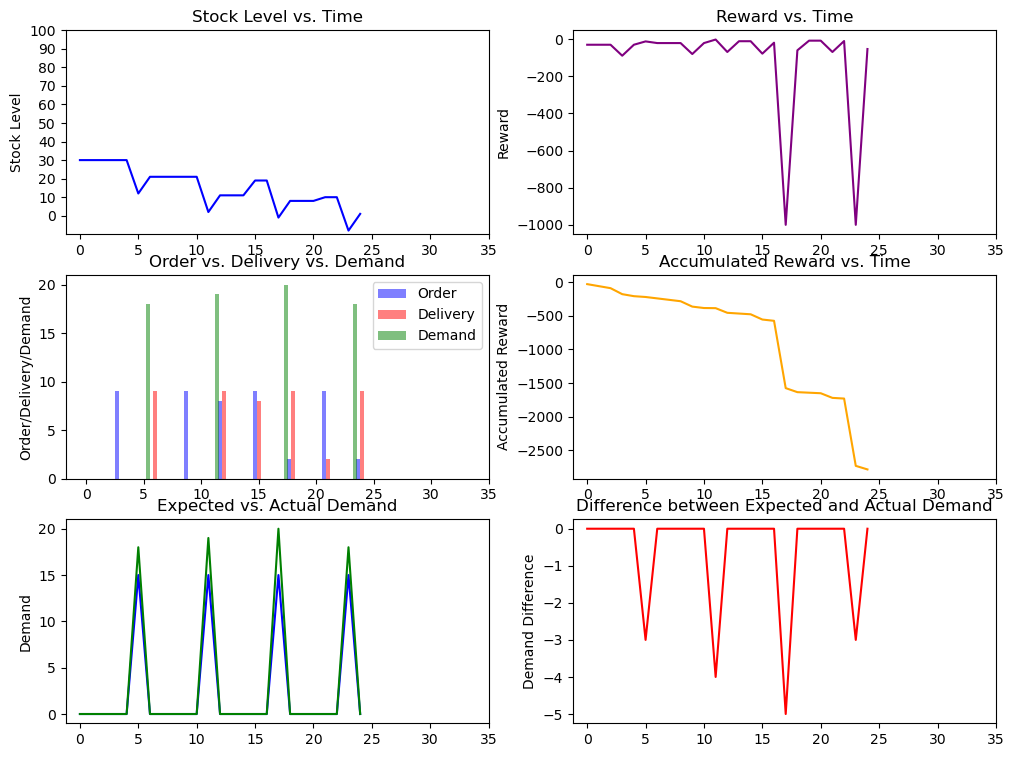

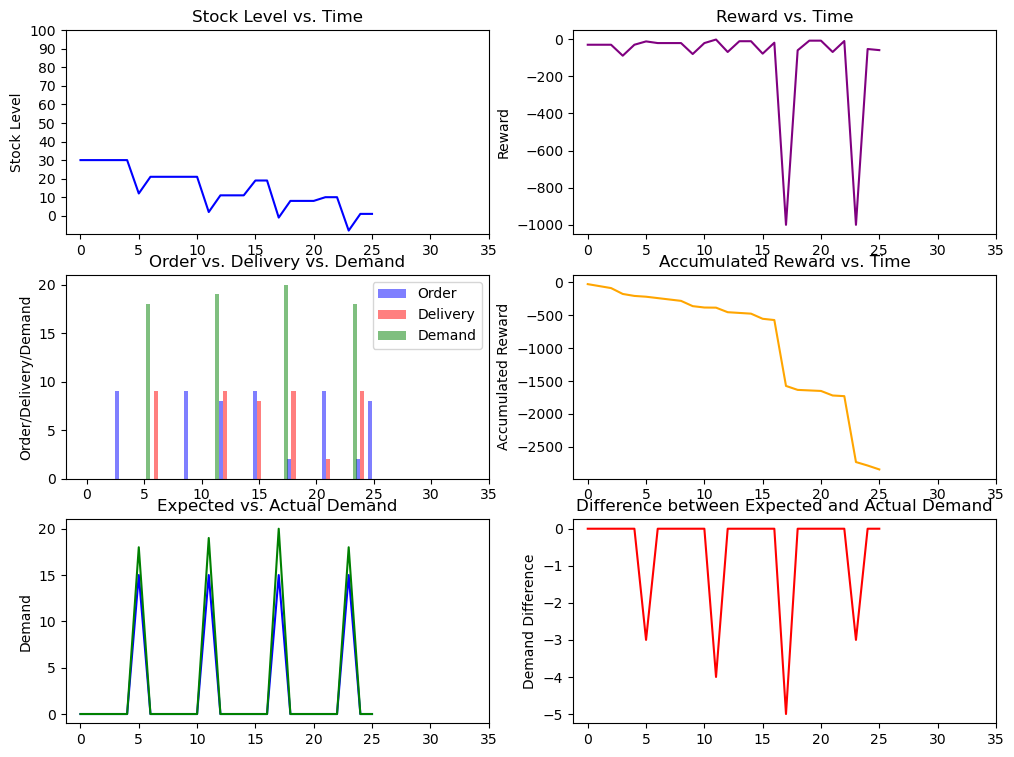

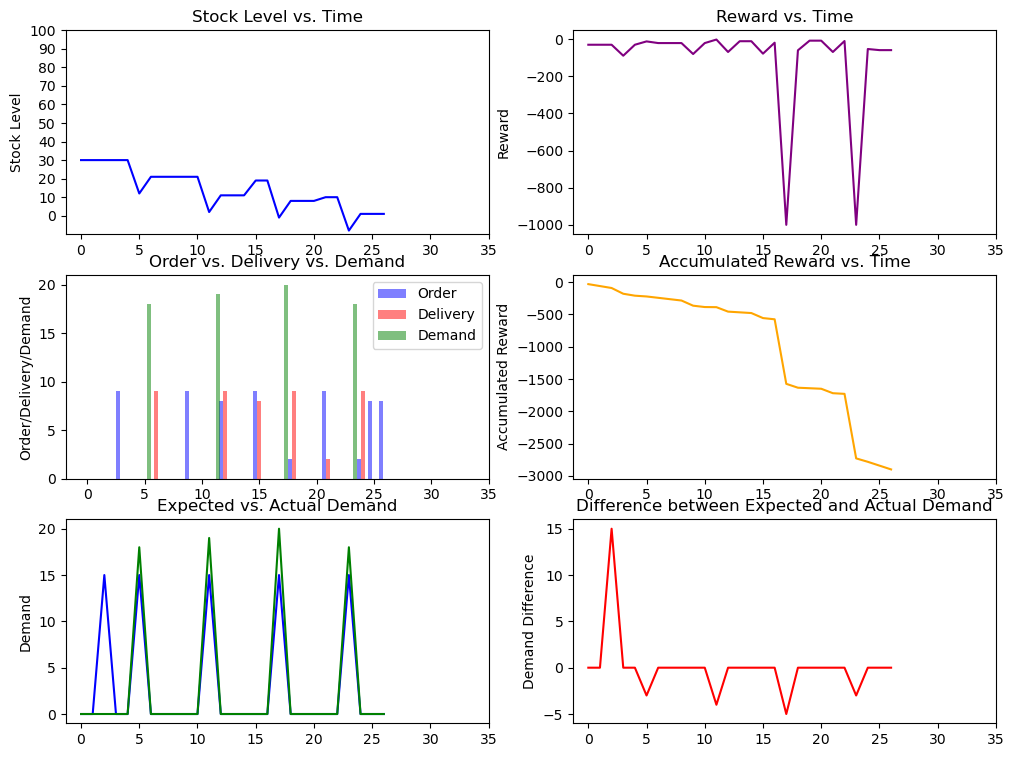

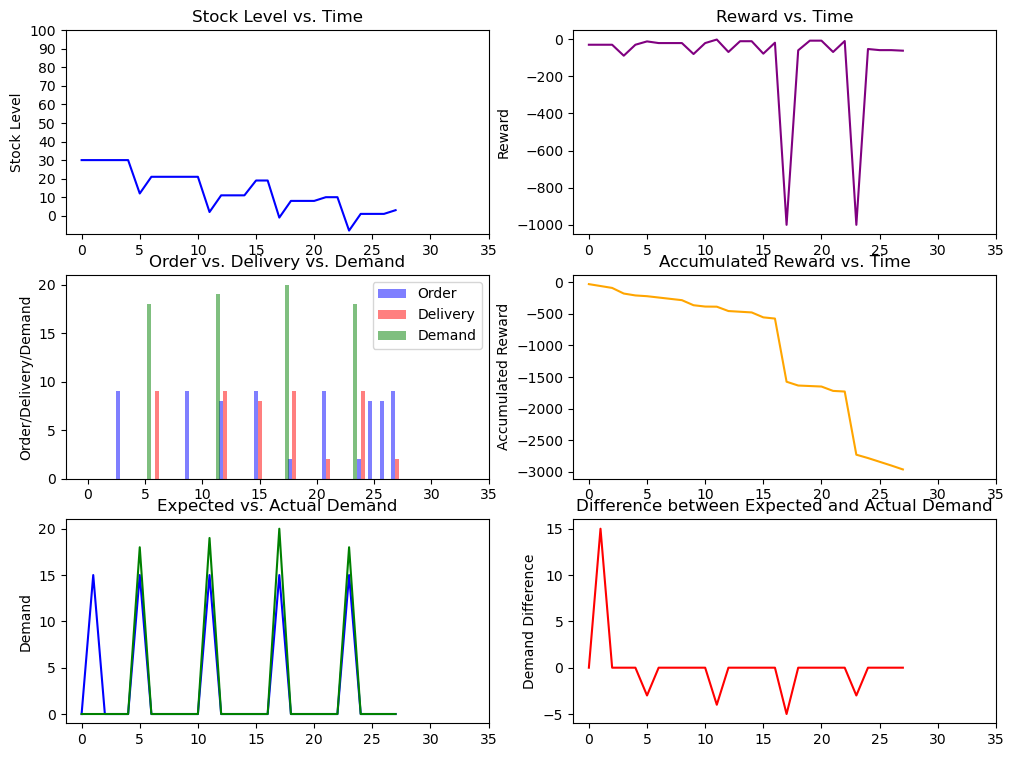

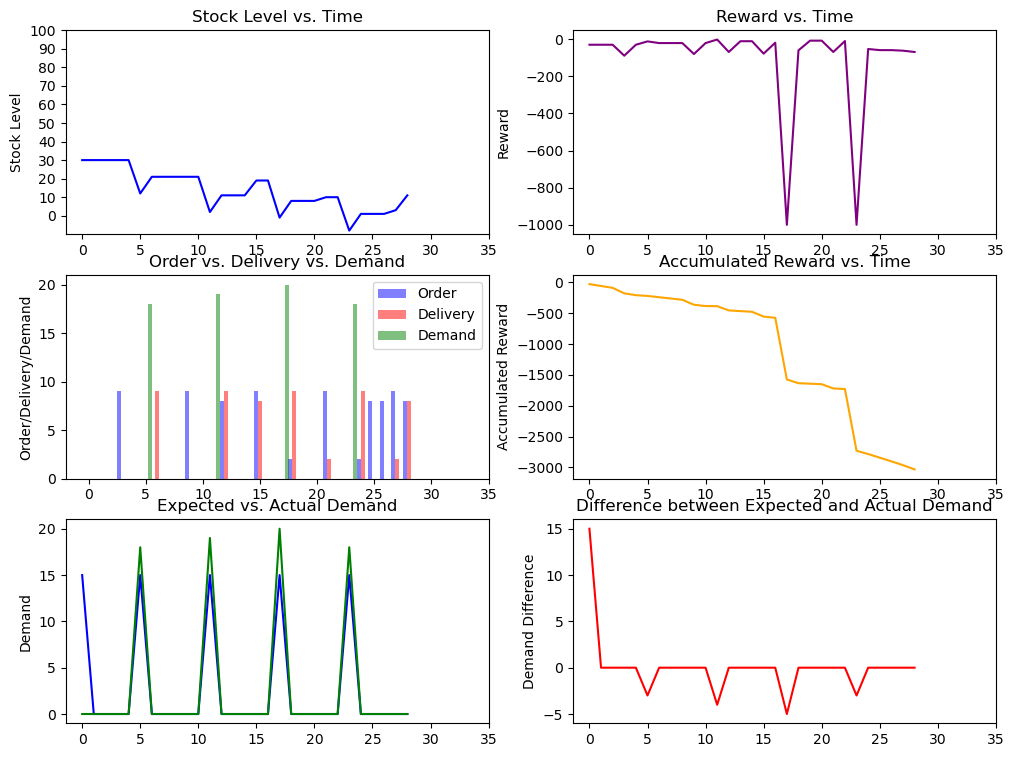

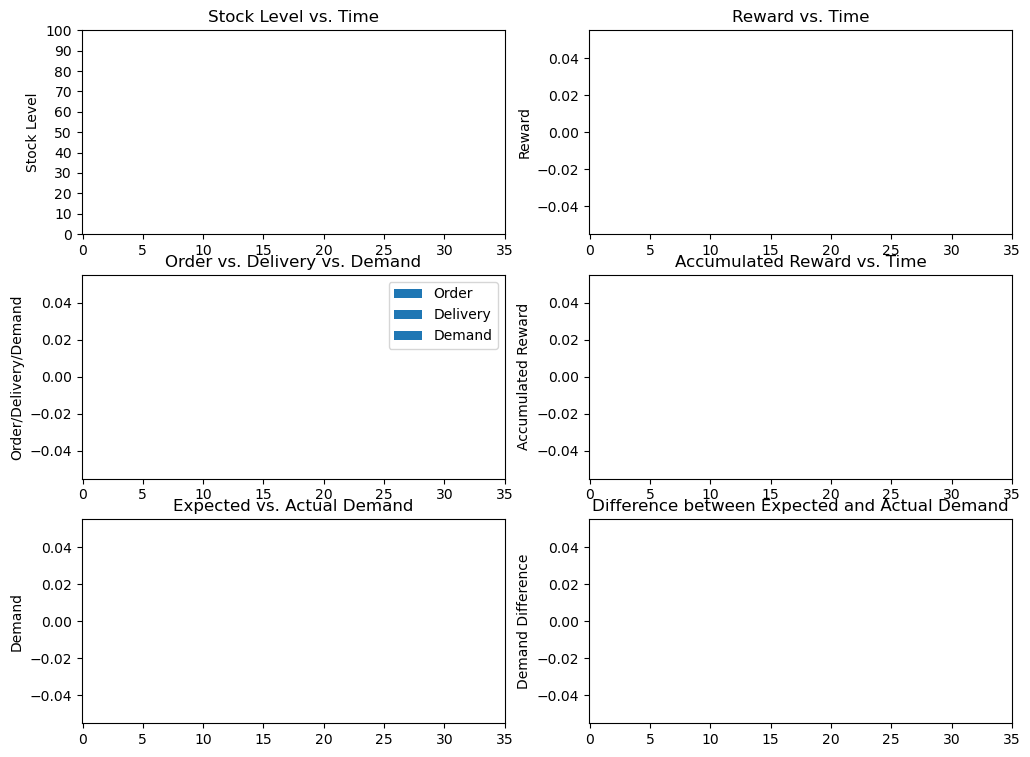

In [53]:
model = PPO.load(model_path, env = env)

env = SS_Mngmt_Env(render_mode="human")

evaluate_policy(model, env, n_eval_episodes=1, render=True, return_episode_rewards=True)

In [ ]:
# TODO new visualuzation based on dataframe data